# Low-Rank and Linear Spectral Matrix Completion for Playlist Recommendation

In [1]:
# -*- coding: utf8 -*-
import sys
import os
import time
import operator
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
import scipy.sparse
import itertools
import random
import IPython.utils.path
from sklearn.cross_validation import train_test_split


%matplotlib inline
mpl.rcParams['axes.edgecolor'] = 'grey'
mpl.rcParams['grid.color'] = '#66CCCC'
mpl.rcParams['text.color'] = '#0EBFE9'
mpl.rcParams['xtick.color'] = '#66CCCC'
mpl.rcParams['ytick.color'] = '#66CCCC'
mpl.rcParams['axes.labelcolor'] = '#0EBFE9'

import recog 

%load_ext autoreload
%autoreload 2

# reload(sys)  # Reload does the trick!
# sys.setdefaultencoding('UTF8')

# pd.options.display.encoding = 'utf-8'

In [3]:
import bokeh.plotting as bp
from bokeh.palettes import brewer
bp.output_notebook()

# Test on real data

In [4]:
def plot_mat(x, title, fig=(512, 200), cmap='Greys', reverse=False, nb_colors=9):
    f1 = bp.figure(plot_width=fig[0], plot_height=fig[1], 
                   x_range=[0, x.shape[1]], y_range=[0, x.shape[0]])
    

    pal = brewer[cmap][nb_colors]
    if reverse:
        pal = pal[::-1]
        
    f1.image(image=[x], x=[0], y=[0], 
             dw=[x.shape[1]], dh=[x.shape[0]], palette=pal)
    f1.title = title
    f1.title_text_color = 'red'
    f1.title_text_font_style = 'bold'
    bp.show(f1)

In [5]:
# DATA_DIR = os.path.join(IPython.utils.path.get_home_dir(), 'data/aotmv2/')
DATA_DIR = os.path.join( IPython.utils.path.get_home_dir(), 'local/aotmv2/')
print 'Data directory:', DATA_DIR

DATASET_NAME = 'aotm'
MAX_PROCESS = 8
song_id_key = 'aotm_id'
playlist_id_key = 'mix_id'
playlist_cat_key = 'playlist_category'

Data directory: /Users/kikohs/local/aotmv2/


In [6]:
FULL_SONGS = pd.read_hdf(os.path.join(DATA_DIR, DATASET_NAME + '_songs.h5'), 'data')
FULL_SONGS.rename(columns={'temporal_echonest_features': 'ten'}, inplace=True)
FULL_PLAYLISTS = pd.read_hdf(os.path.join(DATA_DIR, DATASET_NAME + '_playlists.h5'), 'data')
FULL_MIXES = pd.read_hdf(os.path.join(DATA_DIR, DATASET_NAME + '_mixes.h5'), 'data')

In [7]:
# Extract features only from data
to_remove = set(['title', 'artist_name', 'genre', 'top_genres', 'terms', 
                 'release', 'key', 'mode', 'genre_topics', 'genre_topic', 'ncut_id'])
columns = set(FULL_SONGS.columns.tolist())
feat_col = list(columns - to_remove)

### Create smaller dataset from AOTM data

Here we remove ambiguous plyalist categories, we also verify that there are a sufficient number of playlists in each category. Each playlist is composed of "popular songs", (songs seen at least in a certain amount of playlists), and is not too short not too long.

In [8]:
# min_playlists = 70
min_playlists = 100
# min_playlist_size = 8
min_playlist_size = 5
max_playlist_size = 20
min_popularity = 5

to_remove = ['Mixed Genre', 'Theme', 'Single Artist', 'Alternating DJ', 'Mixed', 'Cover', 'Narrative']

In [9]:
# Remove ambiguous categories
FILT_MIXES = FULL_MIXES[~FULL_MIXES.playlist_category.isin(to_remove)]
# Remove too short or too long playlists
FILT_MIXES = FILT_MIXES[FILT_MIXES['size'].between(min_playlist_size, max_playlist_size)]

# Filter popular songs
good_playlist_categories = np.unique(FILT_MIXES.playlist_category.values)
FILT_PLAYLISTS = FULL_PLAYLISTS[FULL_PLAYLISTS[playlist_cat_key].isin(good_playlist_categories)]
song_popularity_hist = FILT_PLAYLISTS.aotm_id.value_counts()
good_songs = song_popularity_hist[song_popularity_hist >= min_popularity].index.values
FILT_MIXES[song_id_key] = FILT_MIXES[song_id_key].apply(lambda x: list((set(x) & set(good_songs))))
FILT_MIXES['size'] = FILT_MIXES[song_id_key].apply(len)

# Refilter size of playlists
FILT_MIXES = FILT_MIXES[FILT_MIXES['size'].between(min_playlist_size, max_playlist_size)]
# Keep a sufficient number of playlist in each category
p_hist = FILT_MIXES[playlist_cat_key].value_counts()
P_CATEGORIES = p_hist.index[np.where(p_hist > min_playlists)].values
FILT_MIXES = FILT_MIXES[FILT_MIXES[playlist_cat_key].isin(P_CATEGORIES)]

# Update the list of valid songs since we removed some playlists
good_songs = np.unique(list(itertools.chain(*list(FILT_MIXES[song_id_key].values))))
FILT_PLAYLISTS = FILT_PLAYLISTS[FILT_PLAYLISTS[playlist_id_key].isin(FILT_MIXES.index.values)]
FILT_PLAYLISTS = FILT_PLAYLISTS[FILT_PLAYLISTS[song_id_key].isin(good_songs)]

# Keep only valid song and features in playlists
FILT_SONGS = FULL_SONGS[FULL_SONGS.index.isin(good_songs)].sort('genre')
FILT_FEAT = FILT_SONGS[feat_col]

print 'Number of playlists:', len(FILT_MIXES)
print 'Number of songs:', len(FILT_SONGS)

Number of playlists: 12520
Number of songs: 11046


In [10]:
FILT_MIXES[playlist_cat_key].value_counts()

Rock/Pop            2957
Indie Rock          2786
Romantic            1834
Road Trip           1230
Depression           818
Break Up             746
Punk                 609
Sleep                429
Hip Hop              308
Dance/House          154
Indie                154
Electronic Music     138
Rock                 128
Rhythm and Blues     122
Country              107
dtype: int64

### Create evenly sampled dataset

In [11]:
to_keep = ['Romantic', 'Depression', 'Break Up', 'Sleep',
           'Punk', 'Country', 'Hip Hop', 'Dance/House', 'Rock', 'Rhythm and Blues']

P_CATEGORIES = to_keep

cat_size = 50

MINI_MIXES = FILT_MIXES[FILT_MIXES.playlist_category.isin(to_keep)]

tmp = MINI_MIXES.reset_index().groupby(playlist_cat_key).agg({playlist_id_key: lambda x: random.sample(x, cat_size)})
good_mixes = np.unique(list(itertools.chain(*list(tmp[playlist_id_key].values))))

MINI_MIXES = MINI_MIXES[MINI_MIXES.index.isin(good_mixes)]
# sample_idx = random.sample(MINI_MIXES.index, len(MINI_MIXES) // sample_factor)
# MINI_MIXES = MINI_MIXES[MINI_MIXES.index.isin(sample_idx)]
# Update the list of valid songs since we removed some playlists
good_songs = np.unique(list(itertools.chain(*list(MINI_MIXES[song_id_key].values))))
MINI_PLAYLISTS = FILT_PLAYLISTS[FILT_PLAYLISTS[playlist_id_key].isin(MINI_MIXES.index.values)]
MINI_PLAYLISTS = MINI_PLAYLISTS[MINI_PLAYLISTS[song_id_key].isin(good_songs)]

# Keep only valid song and features in playlists
MINI_SONGS = FILT_SONGS[FILT_SONGS.index.isin(good_songs)].sort('genre')
MINI_FEAT = MINI_SONGS[feat_col]

print 'Number of playlists:', len(MINI_MIXES)
print 'Number of songs:', len(MINI_SONGS)

Number of playlists: 500
Number of songs: 2662


In [12]:
MINI_MIXES[playlist_cat_key].value_counts()

Depression          50
Rhythm and Blues    50
Hip Hop             50
Sleep               50
Dance/House         50
Rock                50
Punk                50
Country             50
Romantic            50
Break Up            50
dtype: int64

### Select working dataset

In [13]:
MIXES = MINI_MIXES
FEAT = MINI_FEAT
PLAYLISTS = MINI_PLAYLISTS
SONGS = MINI_SONGS

In [68]:
MIXES = FILT_MIXES
FEAT = FILT_FEAT
PLAYLISTS = FILT_PLAYLISTS
SONGS = FILT_SONGS

## Training part

First, create train and test dataset

In [69]:
train_set_size = 0.7

In [70]:
mixes_train_idx, mixes_test_idx = train_test_split(MIXES.index.values, train_size=train_set_size)
mixes_train_idx, mixes_test_idx = sorted(mixes_train_idx), sorted(mixes_test_idx)

MIXES_train = MIXES[MIXES.index.isin(mixes_train_idx)]
MIXES_test = MIXES[MIXES.index.isin(mixes_test_idx)]

songs_train_list = np.unique(list(itertools.chain(*list(MIXES_train[song_id_key].values))))
songs_test_list = np.unique(list(itertools.chain(*list(MIXES_test[song_id_key].values))))

### Create song graph

To keep the same number of nodes, we create the full song graph and we remove edges not in the train set.

In [ ]:
SONG_GRAPH, SONGS = recog.graph.create_song_graph(FEAT, SONGS, 10)
print nx.info(SONG_GRAPH)

In [ ]:
SONG_GRAPH_train = recog.graph.remove_edges_keep_nodes(SONG_GRAPH.copy(), songs_test_list, SONGS.index)
SONG_GRAPH_train.name += ' train'
print nx.info(SONG_GRAPH_train)

#### Plot adjacency matrix

In [ ]:
W_SONGS = nx.to_scipy_sparse_matrix(SONG_GRAPH)
recog.plot_factor_mat(W_SONGS.todense())
# plot_mat(W_SONGS.todense(), 'Song graph ncut', fig=(512, 512))

In [ ]:
W_SONGS_train = nx.to_scipy_sparse_matrix(SONG_GRAPH_train)
recog.plot_factor_mat(W_SONGS_train.todense())

### Create playlist graph

In [ ]:
PLAYLIST_GRAPH, MIXES = recog.graph.create_playlist_graph(MIXES.copy(), PLAYLISTS, playlist_id_key, song_id_key, 
                                                       'playlist_category', 0.3, 0.2)
print nx.info(PLAYLIST_GRAPH)

In [ ]:
PLAYLIST_GRAPH_train = recog.graph.remove_edges_keep_nodes(PLAYLIST_GRAPH.copy(), MIXES_test.index.values, MIXES.index)
PLAYLIST_GRAPH_train.name += ' train'
print nx.info(PLAYLIST_GRAPH_train)

#### Plot adjacency matrix

In [ ]:
W_PLAYLISTS = nx.to_scipy_sparse_matrix(PLAYLIST_GRAPH)
recog.plot_factor_mat(W_PLAYLISTS.toarray())

In [ ]:
W_PLAYLISTS_train = nx.to_scipy_sparse_matrix(PLAYLIST_GRAPH_train)
recog.plot_factor_mat(W_PLAYLISTS_train.toarray())

In [ ]:
MIXES.groupby('ncut_id')['playlist_category'].value_counts()

### Create C matrix

In [ ]:
C = recog.create_recommendation_matrix(MIXES, SONGS.index,
                                     playlist_id_key, DATASET_NAME, normalize=True)

### Plot C

In [ ]:
recog.plot_factor_mat(C.toarray())
# plot_mat(C.toarray(), 'C', (512, 512))
print 'Sparsity ratio:', C.nnz / float(C.shape[0] * C.shape[1])
print C.shape

In [ ]:
mapped_test_idx = [MIXES.index.get_loc(m) for m in mixes_test_idx]
C_train = C.toarray()
C_train[mapped_test_idx] = 0
C_train = sp.sparse.csr_matrix(C_train)

recog.plot_factor_mat(C_train.toarray())
# plot_mat(C_train.toarray(), 'C', (512, 512))
print 'Sparsity ratio:', C_train.nnz / float(C_train.shape[0] * C_train.shape[1])
print C_train.shape

In [ ]:
rank = len(P_CATEGORIES)
theta_tv_playlist = 10e4 / C.shape[0]
theta_tv_songs = 2.0 / C.shape[1]

# theta_tv_playlist = 0
# theta_tv_songs = 0

print 'theta_tv_playlist:', theta_tv_playlist
print 'theta_tv_songs:', theta_tv_songs
print

A, B = recog.proximal_training(C_train, PLAYLIST_GRAPH_train, SONG_GRAPH_train, rank, 
                             theta_tv_a=theta_tv_playlist, theta_tv_b=theta_tv_songs, 
                             nb_iter_max=20,
                             nb_min_iter=4, 
                             stop_criterion=1e-3,
                             min_iter_inner=50, 
                             max_iter_inner=800,  # do more iterations
                             verbose=1)  # optional A and B to resume iterations

### Plot results

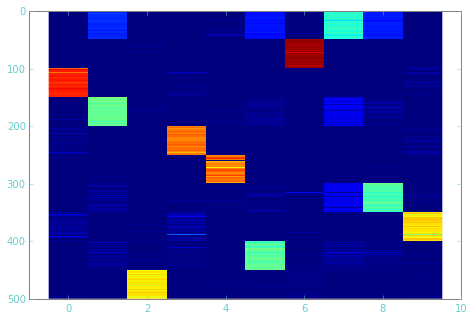

In [44]:
# plot_mat(A, 'A')
recog.plot_factor_mat(A)

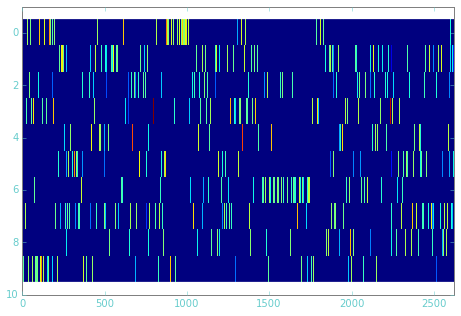

In [45]:
# plot_mat(B, 'B')
recog.plot_factor_mat(B)

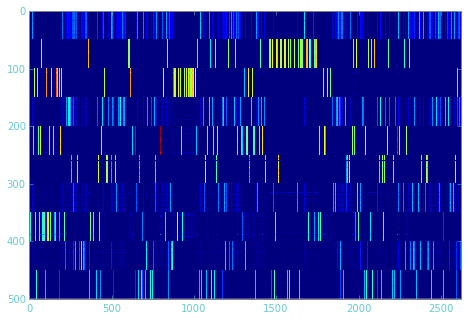

In [46]:
# plot_mat(A.dot(B), 'C = A.dot(B)', reverse=False)
recog.plot_factor_mat(A.dot(B))

## Recommender part

Now that the model is trained, we recommend playlists using the test set.

In [47]:
SONG_TO_IDX = dict(zip(SONGS.index.values, itertools.count()))
np.unique(MIXES[playlist_cat_key]).tolist()

playlist_size = 30
sample_size = 10
nb_sampled_playlists = 30

In [48]:
MIXES_test[playlist_cat_key].value_counts()

Break Up            18
Hip Hop             17
Rhythm and Blues    16
Country             16
Romantic            16
Dance/House         15
Punk                14
Sleep               14
Depression          13
Rock                11
dtype: int64

### Use A and B

In [49]:
start = time.time()
results_test = recog.test_playlists(MIXES_test, PLAYLISTS, SONGS, A, B, playlist_size, 
                                    SONG_TO_IDX, song_id_key, playlist_cat_key, use_both=True) 
mean_results_test = results_test.groupby(playlist_cat_key).agg({'score': np.mean})

results_sampled = recog.sampled_vs_random(nb_sampled_playlists, P_CATEGORIES, PLAYLISTS, SONGS, 
                                    sample_size, A, B, playlist_size, SONG_TO_IDX, song_id_key, 
                                          playlist_cat_key, use_both=True)

results = results_sampled
results['test_set'] = mean_results_test
results['test_set / random absolute gain'] = (results['test_set'] - results['random']) * 100
results['test_set / random relative gain'] = ((results['test_set'] / results['random']) - 1) * 100

print 'Done in {} seconds'.format(time.time() - start)

Done in 25.9540169239 seconds


In [50]:
print 'Average test set:', results['test_set'].mean()

Average test set: 0.521757713964


In [51]:
results

,sampled,random,sampled / random absolute gain,sampled / random relative gain,test_set,test_set / random absolute gain,test_set / random relative gain
playlist_category,,,,,,,
Break Up,0.674444,0.021111,65.333333,3094.736842,0.274074,25.296296,1198.245614
Country,1.000000,0.035556,96.444444,2712.500000,0.937500,90.194444,2536.718750
Dance/House,0.775556,0.082222,69.333333,843.243243,0.666667,58.444444,710.810811
Depression,0.900000,0.100000,80.000000,800.000000,0.494872,39.487179,394.871795
Hip Hop,0.903333,0.135556,76.777778,566.393443,0.605882,47.032680,346.962392
Punk,1.000000,0.520000,48.000000,92.307692,0.714286,19.428571,37.362637
Rhythm and Blues,0.933333,0.100000,83.333333,833.333333,0.750000,65.000000,650.000000
Rock,0.966667,0.101111,86.555556,856.043956,0.360606,25.949495,256.643357
Romantic,0.572222,0.008889,56.333333,6337.500000,0.220833,21.194444,2384.375000


In [52]:
results.mean().reset_index()  # test_set 0.1

,index,0
0,sampled,0.833667
1,random,0.111111
2,sampled / random absolute gain,72.255556
3,sampled / random relative gain,2520.272518
4,test_set,0.521758
5,test_set / random absolute gain,41.064660
6,test_set / random relative gain,1130.884750


## Dump data

In [66]:
def dump(outdir, name='mini'):
    dump_dir = os.path.join(DATA_DIR, 'dump_' + name + '/')
    
    if not os.path.exists(dump_dir):
        os.mkdir(dump_dir)

    nx.write_gpickle(SONG_GRAPH, os.path.join(dump_dir, name + '_song_graph.gpickle'))
    nx.write_gpickle(PLAYLIST_GRAPH, os.path.join(dump_dir, name + '_playlist_graph.gpickle'))
    store = pd.HDFStore(os.path.join(dump_dir, name + '_data.h5'))
    store['songs'] = SONGS
    store['mixes'] = MIXES
    store['results'] = results
    store.close()

    matlab_export_path = os.path.join(dump_dir, name + '_recog_real_data.mat')
    matlab_data = dict()

    matlab_data['C'] = C
    matlab_data['W_a'] = W_PLAYLISTS
    matlab_data['W_b'] = W_SONGS
    matlab_data['A'] = A
    matlab_data['B'] = B
    matlab_data['songs_train'] = songs_train_list
    matlab_data['songs_test'] = songs_test_list
    matlab_data['mixes_train'] = np.array(songs_train_list)
    matlab_data['mixes_test'] = np.array(songs_test_list)

    sp.io.savemat(matlab_export_path, matlab_data)
    print 'Exported file:', matlab_export_path
    
dump(DATA_DIR, 'mini')

Exported file: /Users/kikohs/local/aotmv2/dump_mini/mini_recog_real_data.mat
